# Dogs vs. Cats

https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition

In [1]:
import numpy as np
import cv2
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D
from tensorflow.keras import backend as k
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.callbacks import ReduceLROnPlateau

In [2]:
IMG_SIZE = (299, 299)  # размер входного изображения сети

## Функции загрузки данных

In [3]:
import re
from random import shuffle
from glob import glob

train_files = glob('../input/train/*.jpg')
test_files = glob('../input/test/*.jpg')




# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = load_img(path, target_size=target_size)  # загрузка и масштабирование изображения
    array = img_to_array(img)
    return preprocess_input(array)

traindataag= ImageDataGenerator(rescale=1./255, featurewise_center=True,featurewise_std_normalization=True,horizontal_flip=True, fill_mode='nearest', zoom_range=0.3, width_shift_range=0.3, height_shift_range=0.3, rotation_range=30)

# генератор для последовательного чтения обучающих данных с диска
def fit_generator(files, batch_size=256):
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if 'dog' in path else 0. for path in files[i:j]])
            traindataag.fit(x)
            yield traindataag.flow(x,y, batch_size), (x,y)

# генератор последовательного чтения тестовых данных с диска
def predict_generator(files):
    while True:
        for path in files:
            yield np.array([load_image(path)])

## Визуализируем примеры для обучения

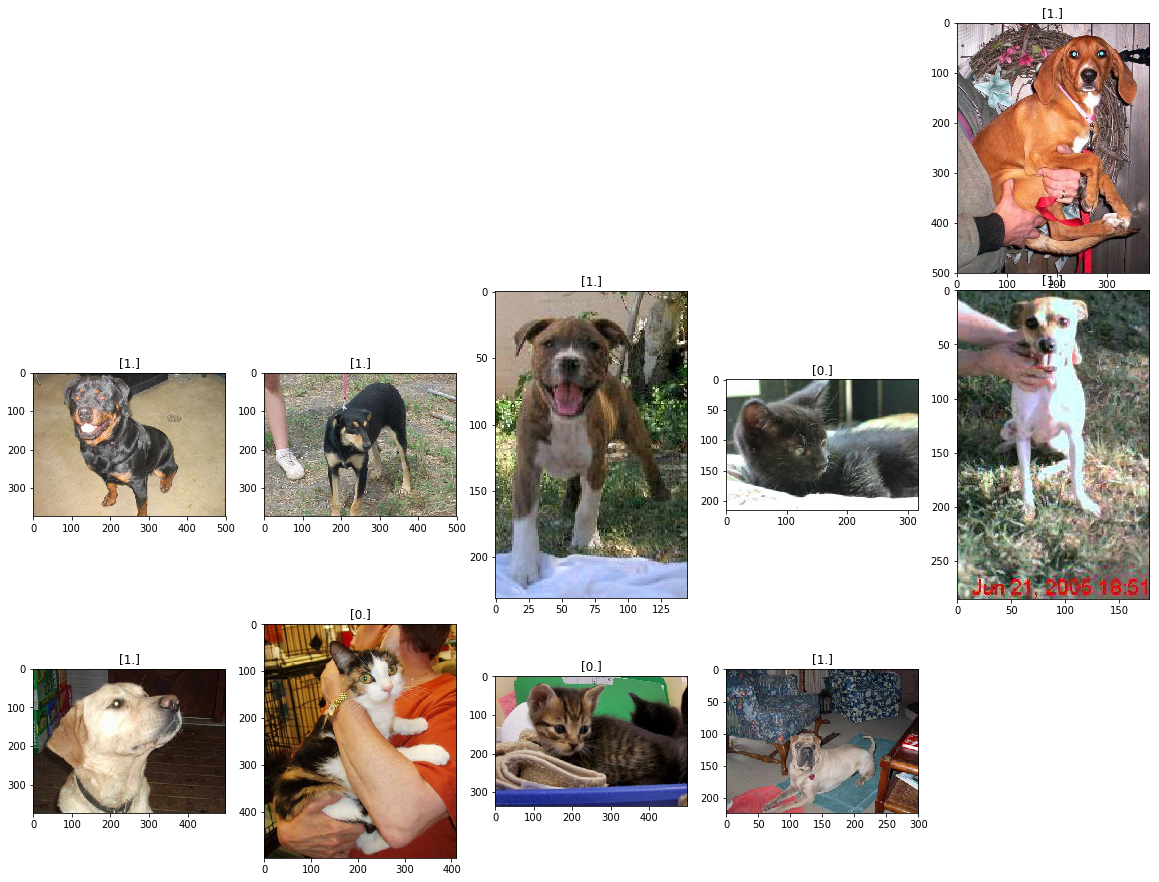

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, path in enumerate(train_files[10:20], 1):
    y1 = np.array([1. if 'dog' in path else 0.])
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%s' % y1);

## Загружаем предобученную модель

In [5]:
# base_model -  объект класса keras.models.Model (Functional Model)
base_model = InceptionV3(include_top = False,
                   weights = 'imagenet',
                   input_shape = (IMG_SIZE[0], IMG_SIZE[1], 3))

87916544/87910968 [==============================] - 2s 0us/step


In [6]:
base_model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [7]:
batch_norm_layers=[base_model.layers.index(x) for x in base_model.layers if 'norm' in str(x)]

In [8]:
batch_norm_layers=batch_norm_layers[len(batch_norm_layers)//8:]

In [9]:
pool_layers=[base_model.layers.index(x) for x in base_model.layers if 'pooling' in str(x)]

In [10]:
pool_layers=conv_layers[len(pool_layers)//8:]

NameError: name 'conv_layers' is not defined

In [11]:
pool_layers

[10, 17, 27, 50, 73, 99, 119, 151, 183, 215, 247, 262, 293]

In [12]:

for layer_num in range(len(base_model.layers)):
    if layer_num in batch_norm_layers:
        base_model.layers[layer_num]=keras.layers.BatchNormalization(momentum=0.01, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None)

In [13]:
for layer in base_model.layers:
    if layer in batch_norm_layers:
        layer.trainable = True
    else:
        if layer in pool_layers:
            layer.trainable = True
        else:
            layer.trainable = False

## Добавляем полносвязный слой

In [14]:
x = base_model.output
x=GlobalAveragePooling2D()(x)
x = keras.layers.Flatten()(x)
x=keras.layers.BatchNormalization()(x)
x=Dropout(0.5)(x)
x=keras.layers.Dense(256,  
                activation='relu')(x)
x=keras.layers.BatchNormalization()(x)
x=Dropout(0.5)(x)
x=keras.layers.Dense(256,  
                activation='relu')(x)
x=Dropout(0.5)(x)
x = keras.layers.Dense(1,  
                activation='sigmoid')(x)
model = Model(inputs=base_model.input, outputs=x)

 Выводим архитектуру модели

In [15]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
__________________________________________________________________________________________________
conv2d_1 (

In [16]:
opt=keras.optimizers.Adam(lr=0.01, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)

## Компилируем модель и запускаем обучение

In [17]:
model.compile(optimizer=opt, 
              loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
              metrics=['accuracy'])

In [18]:
shuffle(train_files)  # перемешиваем обучающую выборку

train_val_split = 100  # число изображений в валидационной выборке

validation_data = next(fit_generator(train_files[:train_val_split], train_val_split))[1]
train_data = next(fit_generator(train_files[train_val_split:]))[0]
reduce_lr=ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.00001)

# запускаем процесс обучения
model.fit_generator(train_data,  # данные читаем функцией-генератором
        steps_per_epoch=10,  # число вызовов генератора за эпоху
        epochs=20,  # число эпох обучения
        validation_data=validation_data, callbacks=[reduce_lr])

Epoch 1/20
10/10 [==============================] - 80s 8s/step - loss: 0.2312 - acc: 0.9039 - val_loss: 2.6460 - val_acc: 0.5600
Epoch 2/20
10/10 [==============================] - 56s 6s/step - loss: 0.0761 - acc: 0.9762 - val_loss: 1.7835 - val_acc: 0.6700
Epoch 3/20
10/10 [==============================] - 59s 6s/step - loss: 0.0511 - acc: 0.9801 - val_loss: 0.5986 - val_acc: 0.8100
Epoch 4/20
10/10 [==============================] - 60s 6s/step - loss: 0.0450 - acc: 0.9840 - val_loss: 0.4026 - val_acc: 0.8500
Epoch 5/20
10/10 [==============================] - 60s 6s/step - loss: 0.0456 - acc: 0.9832 - val_loss: 0.1842 - val_acc: 0.9400
Epoch 6/20
10/10 [==============================] - 59s 6s/step - loss: 0.0478 - acc: 0.9855 - val_loss: 0.1219 - val_acc: 0.9400
Epoch 7/20
10/10 [==============================] - 59s 6s/step - loss: 0.0275 - acc: 0.9887 - val_loss: 0.3007 - val_acc: 0.8500
Epoch 8/20
10/10 [==============================] - 60s 6s/step - loss: 0.0420 - acc: 0.98

In [19]:
model.save('cats-dogs-incv3.hdf5')

## Предсказания на проверочной выборке

In [20]:
pred = model.predict_generator(predict_generator(test_files), len(test_files), max_queue_size=500)

In [21]:
pred

array([[9.7225934e-01],
       [9.3159791e-08],
       [9.9981099e-01],
       ...,
       [3.7707917e-09],
       [2.1145598e-10],
       [8.7238634e-01]], dtype=float32)

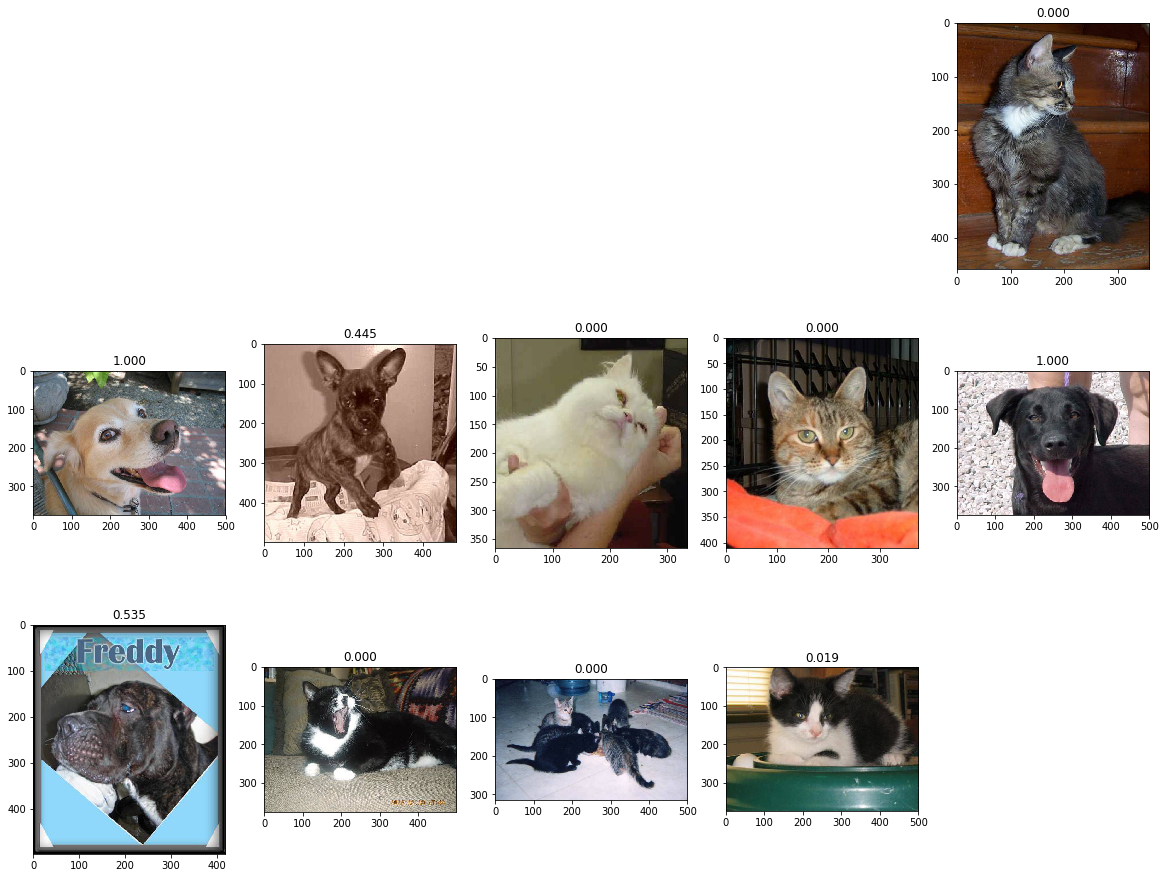

In [22]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(20, 20))
for i, (path, score) in enumerate(zip(test_files[80:][:10], pred[80:][:10]), 1):
    subplot = fig.add_subplot(i // 5 + 1, 5, i)
    plt.imshow(plt.imread(path));
    subplot.set_title('%.3f' % score);

## Готовим данные для сабмита

In [23]:
with open('submission.txt', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, pred):
        dst.write('%s,%f\n' % (re.search('(\d+)', path).group(0), score))

In [24]:
# LogLoss = 0,21